# CountGPVAE Simulation Demo

This notebook demonstrates how to use the modularized components of the CountGPVAE model.

In [1]:
import os
import jax
import jax.nn as nn
import math
import itertools
from jax import lax, random
from jax.example_libraries import stax
import jax.numpy as jnp
from jax.random import PRNGKey
import numpy as np
import numpyro
import pickle
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, RenyiELBO
import arviz as az
import sys
from pyprojroot import here
import time
import plotly.express as px
import geopandas as gpd
sys.path.append(str(here() / "simulation study" / "src"))
# Import our modular components
from kernels import exp_sq_kernel, M_g
from loader_jkt import load_data
from gp import gp_aggr
from vae import vae_model, vae_guide, vae_decoder
from plotting import plot_process, plot_incidence_map
import matplotlib.pyplot as plt
from numpyro.infer import NUTS, MCMC, Predictive, init_to_median, init_to_uniform, init_to_sample, init_to_mean, init_to_value

C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Data

In [2]:
# Load the spatial grid and polygon data
spatial_data = load_data()
print(spatial_data.keys())

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])


## 2. Set up Model Parameters

In [153]:
# Model configuration
args = {
    "x": spatial_data["x"],
    "gp_kernel": exp_sq_kernel,
    "noise": 1.e-2,
    "jitter": 1.e-2,
    "M_lo": jnp.array(spatial_data["pol_pts_lo"]),
    "M_hi":  jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    "vae_var": 0.1,
    "batch_size": 5,
    "hidden_dim": 50,
    "z_dim": 40,
    "learning_rate": 1e-3,
    "num_epochs": 50,
    "rng_key": PRNGKey(6)
}

## 3. Generate GP Samples

In [4]:
# Create predictive function for GP
from numpyro.infer import Predictive
# Draw samples from the prior
prior_samples = Predictive(gp_aggr, num_samples=5)(
    PRNGKey(6),
    config=args
)

# transform prior samples to arviz inference object
prior_samples_arviz = az.from_numpyro(prior=prior_samples)

plot_process(prior_samples_arviz.prior.gp_aggr.values)

## 4. Train VAE

In [18]:
# Initialize SVI
optimizer = numpyro.optim.Adam(step_size=1e-3)
agg_gp_predictive = Predictive(gp_aggr,num_samples = 5)
@jax.jit
def epoch_train(rng_key, svi_state, num_train):
    def body_fn(i, val):
        rng_key_i = jax.random.fold_in(rng_key, i) #Array(2,)
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = jax.random.split(rng_key_i, 4) #Tuple(Array(2,) x 4)
        loss_sum, svi_state = val #val --svi_state

        batch = agg_gp_predictive(rng_key_i, args)["gp_aggr"] #(5,116) <- num_samples : 5, total_districts : 116
        #* svi is where the vae_model & vae_guide gets applied
        svi_state, loss = svi.update(svi_state, batch)
        loss_sum += loss / args["batch_size"]
        return loss_sum, svi_state

    return lax.fori_loop(lower = 0, upper = num_train, body_fun=body_fn, init_val=(0.0, svi_state))

@jax.jit
def eval_test(rng_key, svi_state, num_test):
    def body_fn(i, loss_sum):
        rng_key_i = jax.random.fold_in(rng_key, i)
        rng_key_i, rng_key_ls, rng_key_varm, rng_key_noise = jax.random.split(rng_key_i, 4)
        batch = agg_gp_predictive(rng_key_i, args)["gp_aggr"]
        #* svi is where the vae_model & vae_guide gets applied
        loss = svi.evaluate(svi_state, batch) / args["batch_size"]
        loss_sum += loss
        return loss_sum

    loss = lax.fori_loop(lower = 0, upper = num_test,body_fun =  body_fn, init_val = 0.0)
    loss = loss / num_test
    return loss

## Hyerparameter tuning for h and z

In [15]:
# Define hyperparameter grid
hidden_dims = [20, 30, 40, 50]
z_dims = [20, 30, 40, 50]

# Store results
test_loss_results_final = {}
test_loss_results_mean = {}

num_train = 100
num_test = 100
num_epochs = 20

for hidden_dim, z_dim in itertools.product(hidden_dims, z_dims):
    print(f"Training with hidden_dim={hidden_dim}, z_dim={z_dim}")

    args["hidden_dim"] = hidden_dim
    args["z_dim"] = z_dim

    # Initialize optimizer and SVI
    adam = numpyro.optim.Adam(step_size=args["learning_rate"])
    # Pass vae_var to vae_model using a lambda function
    svi = SVI(
        lambda batch: vae_model(batch, hidden_dim, z_dim, args["vae_var"]),
        lambda batch: vae_guide(batch, hidden_dim, z_dim),
        adam,
        RenyiELBO(),
    )

    # Split RNG keys
    rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"], 3)
    init_batch = agg_gp_predictive(rng_key_samp, args)["gp_aggr"]

    # Initialize SVI state
    svi_state = svi.init(rng_key_init, init_batch)

    # Pre-allocate test loss array
    test_loss_list = jnp.zeros(num_epochs)

    # Training loop
    for epoch in range(num_epochs):
        rng_key, rng_key_train, rng_key_test = random.split(rng_key, 3)
        t_start = time.time()

        train_loss, svi_state = epoch_train(rng_key_train, svi_state, num_train)
        test_loss = eval_test(rng_key_test, svi_state, num_test)
        test_loss_list = test_loss_list.at[epoch].set(test_loss)

        print(f"Epoch: {epoch}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f} ({time.time() - t_start:.2f} s)")

        if math.isnan(test_loss):  # Stop early if NaN
            print(f"NaN encountered at hidden_dim={hidden_dim}, z_dim={z_dim}. Skipping...")
            break  # Stop training if NaN occurs

    # Store results only if valid
    if not math.isnan(test_loss_list[-1]):
        test_loss_results_final[(hidden_dim, z_dim)] = test_loss_list[-1]
        test_loss_results_mean[(hidden_dim, z_dim)] = jnp.nanmean(test_loss_list)
        print(f"Final Test loss for hidden_dim={hidden_dim}, z_dim={z_dim}: {test_loss_list[-1]}")
        print(f"Mean Test loss for hidden_dim={hidden_dim}, z_dim={z_dim}: {jnp.nanmean(test_loss_list)}")

print("Grid search complete.")
print("Results:", test_loss_results_final)
print("Mean Test Loss Results:", test_loss_results_mean)

Training with hidden_dim=20, z_dim=20
Epoch: 0, Train Loss: 18298746880.00, Test Loss: 131595576.00 (13.33 s)
Epoch: 1, Train Loss: 28472915968.00, Test Loss: 172952064.00 (0.22 s)
Epoch: 2, Train Loss: 16623357952.00, Test Loss: 162045552.00 (0.22 s)
Epoch: 3, Train Loss: 14992008192.00, Test Loss: 4303764992.00 (0.22 s)
Epoch: 4, Train Loss: 3684347674624.00, Test Loss: 9992914944.00 (0.22 s)
Epoch: 5, Train Loss: 15526137856.00, Test Loss: 361663070208.00 (0.22 s)
Epoch: 6, Train Loss: 18069397504.00, Test Loss: 143981696.00 (0.22 s)
Epoch: 7, Train Loss: 12369376256.00, Test Loss: 140706416.00 (0.22 s)
Epoch: 8, Train Loss: 13913288704.00, Test Loss: 132283504.00 (0.22 s)
Epoch: 9, Train Loss: 10682062848.00, Test Loss: 94213080.00 (0.22 s)
Epoch: 10, Train Loss: 12442591232.00, Test Loss: 130829952.00 (0.22 s)
Epoch: 11, Train Loss: 13886770176.00, Test Loss: 140524736.00 (0.22 s)
Epoch: 12, Train Loss: 12460086272.00, Test Loss: 90007440.00 (0.22 s)
Epoch: 13, Train Loss: 1346216

### Optimal hyperparams with lowest mean test loss and pretty stable final loss is (50, 30)

In [24]:
#-------------------------- Train VAE -------------------------- #
run = True
if run:
    adam = numpyro.optim.Adam(step_size = args["learning_rate"])
    svi = SVI(
        model=lambda batch: vae_model(batch, args["hidden_dim"], args["z_dim"], args["vae_var"]),
        guide=lambda batch: vae_guide(batch, args["hidden_dim"], args["z_dim"]),
        optim=adam,
        loss=RenyiELBO(),
    )
    rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"],3)
    #(num_samples, num_regions)
    init_batch = agg_gp_predictive(rng_key_samp, args)["gp_aggr"] #(num_samples, num_regions) <- i.e (5,58)
    svi_state = svi.init(rng_key_init, init_batch)

    test_loss_list = []

    for i in range(args["num_epochs"]):
        rng_key, rng_key_train, rng_key_test, rng_key_infer = random.split(rng_key, 4)
        t_start = time.time()
        num_train = 1000
        # Where forward/backward pass gets called for train
        train_loss , svi_state = epoch_train(rng_key_train, svi_state, num_train)
        num_test = 1000
        # Where forward/backward pass gets called for test
        test_loss = eval_test(rng_key_test, svi_state, num_test)
        test_loss_list += [test_loss]

        print("Epoch : {}, train loss : {:.2f}, test loss : {:.2f} ({:.2f} s.)".format(i, train_loss, test_loss, time.time() - t_start))
        if np.isnan(test_loss):
            break

Epoch : 0, train loss : 87384735744.00, test loss : 48987672.00 (2.18 s.)
Epoch : 1, train loss : 51568414720.00, test loss : 46541832.00 (2.13 s.)
Epoch : 2, train loss : 50400485376.00, test loss : 50924832.00 (2.15 s.)
Epoch : 3, train loss : 47188566016.00, test loss : 50301468.00 (2.16 s.)
Epoch : 4, train loss : 53695676416.00, test loss : 45515888.00 (2.15 s.)
Epoch : 5, train loss : 47486144512.00, test loss : 49314156.00 (2.15 s.)
Epoch : 6, train loss : 50683342848.00, test loss : 49864968.00 (2.12 s.)
Epoch : 7, train loss : 46715981824.00, test loss : 47474636.00 (2.12 s.)
Epoch : 8, train loss : 49505792000.00, test loss : 50044152.00 (2.13 s.)
Epoch : 9, train loss : 50547527680.00, test loss : 47066100.00 (2.13 s.)
Epoch : 10, train loss : 53543215104.00, test loss : 47809112.00 (2.14 s.)
Epoch : 11, train loss : 47106850816.00, test loss : 50315204.00 (2.14 s.)
Epoch : 12, train loss : 52275843072.00, test loss : 48499768.00 (2.14 s.)
Epoch : 13, train loss : 5012267008

In [20]:
vae_params = svi.get_params(svi_state)

In [21]:
save_dir = "/content/model_weights/aggVAE"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, f"aggVAE_e{args['num_epochs']}_h{args['hidden_dim']}_z{args['z_dim']}.pkl")

with open(save_path, "wb") as file:
    pickle.dump(vae_params, file)

print(f"VAE parameters saved to {save_path}")

VAE parameters saved to /content/model_weights/aggVAE/aggVAE_e50_h50_z30.pkl


## Run MCMC using trained VAE encoder

In [140]:
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e29_h50_z40.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [141]:
N = 6

def vae_sample(args):
    dec_params = args["decoder_params"]
    z_dim, h_dim = dec_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    dec_init_fn, dec_apply_fn = vae_decoder(h_dim, N)
    x_recon = dec_apply_fn(dec_params, z)
    vae_aggr = numpyro.deterministic("vae_aggr", x_recon)
    return vae_aggr

rng_key, rng_key_predict = random.split(random.PRNGKey(3))
vae_predictive = Predictive(vae_sample, num_samples = 5)
vae_draws = vae_predictive(rng_key_predict, args)["vae_aggr"]

In [142]:
plot_process(jnp.expand_dims(vae_draws, axis = 0))

In [143]:
# ------------------- Func for Agg VAE Prev ------------------- #
def prev_model_vae_aggr(config=None):

    if config is None:
        config = {}

    # Set defaults
    x = config.get('x', None)
    gp_kernel = config.get('gp_kernel', exp_sq_kernel)
    noise = config.get('noise', 1e-4)
    jitter = config.get('jitter', 1e-4)
    M_lo = config.get('M_lo', None)
    M_hi = config.get('M_hi', None)
    kernel_length_prior = config.get('kernel_length', dist.InverseGamma(4, 1))
    kernel_var_prior = config.get('kernel_var', dist.LogNormal(0, 0.1))
    pop_density = config.get('pop_density', None)
    urban_frac = config.get('urban_frac', None)
    hdi_index = config.get('hdi_index', None)
    count = config.get("count", None)

     # Total cases: pass in low prev counts, mask high prev ones as NaN
    count_mask = ~jnp.isnan(count)

    total_population = config.get('total_population', None)
    is_prior_pred = config.get('prior_pred', False)
    out_dims = config.get('out_dims', 6)
    # GP
    config_gp = config.copy()
    config_gp['x'] = x
    config_gp['gp_kernel'] = gp_kernel
    config_gp['noise'] = noise
    config_gp['jitter'] = jitter
    config_gp['M_lo'] = M_lo
    config_gp['M_hi'] = M_hi
    config_gp['kernel_length'] = kernel_length_prior
    config_gp['kernel_var'] = kernel_var_prior
    # Call gp_aggr
    decoder_params = config["decoder_params"]
    z_dim, hidden_dim = decoder_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    _, decoder_apply = vae_decoder(hidden_dim, out_dims) #Instantiate decoder
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_apply(decoder_params, z))
    s = numpyro.sample("sigma1", dist.HalfNormal(200))

    vae = numpyro.deterministic("vae", s * vae_aggr)

    # Fixed effects
    b0 = numpyro.sample("b0", dist.Normal(100, 10))  # Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 1))  # Effect of population density
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 1))  # Effect of HDI
    b_urban = numpyro.sample("b_urban", dist.Normal(0, 1))  # Effect of urbanicity

    # Linear predictor
    # lp = numpyro.deterministic("lp", (b0 +
    #                                   aggr_gp +
    #                                   b_pop_density * pop_density +
    #                                   b_hdi * hdi_index +
    #                                   b_urban * urban_frac))  #
    lp = numpyro.deterministic("lp", nn.softplus(b0 +
                                      vae +
                                      b_pop_density * pop_density +
                                      b_hdi * hdi_index +
                                      b_urban * urban_frac))


    sigma = numpyro.sample("sigma", dist.HalfNormal(5))

    # Full predictions (no masking)
    full_pred_cases = numpyro.sample(
        "full_pred_cases",
        dist.Normal(lp, sigma))

    # Observed only where count is available
    with numpyro.handlers.mask(mask=count_mask):
        numpyro.sample(
            "pred_cases",  # not used for return
            dist.Normal(lp, sigma),
            obs=None if is_prior_pred else count)

    # Store full predictions
    numpyro.deterministic("pred_cases_out", full_pred_cases)


In [144]:
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data
year_data = 2020
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the most recent year
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population
total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])
Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2020



In [145]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [146]:
model =  prev_model_vae_aggr
n_samples = 1000
# Define the sampler
sampler = NUTS(model)
mcmc = MCMC(sampler,
            num_warmup=1000,
            num_samples=n_samples,
            num_chains=4,
            chain_method="vectorized",
            )
start = time.time()
mcmc.run(PRNGKey(2), config_count)
end = time.time()
t_elapsed_min = round((end - start) / 60)
print(f"Time taken to run MCMC: {t_elapsed_min} minutes")

sample: 100%|██████████| 2000/2000 [01:31<00:00, 21.78it/s]

Time taken to run MCMC: 2 minutes


In [154]:
#save mcmc for aggVAE jkt yearly (change the year manually)
# Save the MCMC object as a pickle file
# Define the path where you want to save the MCMC files

save_dir = "../model weights/aggVAEPrev"
os.makedirs(save_dir, exist_ok=True)

# Define the file path where to save the MCMC object
file_path = os.path.join(save_dir, f"mcmc_jkt_{year_data}_{t_elapsed_min}min_z{args["z_dim"]}_{n_samples}.pkl")

# Save the MCMC object as a pickle file
with open(file_path, 'wb') as f:
        pickle.dump(mcmc, f)

print(f"MCMC object for year {year_data} saved successfully at {file_path}.")

MCMC object for year 2020 saved successfully at ../model weights/aggVAEPrev\mcmc_jkt_2020_2min_z40_1000.pkl.


In [148]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    100.48     10.38    100.19     83.25    117.21    131.09      1.01
             b_hdi     -0.02      0.97     -0.04     -1.61      1.51     21.26      1.08
     b_pop_density      0.08      0.97      0.07     -1.50      1.71    188.31      1.02
           b_urban     -0.35      1.17     -0.38     -2.38      1.50      4.66      1.36
full_pred_cases[0]   1216.48     10.25   1217.34   1202.74   1232.41     44.55      1.10
full_pred_cases[1]    225.25    134.55    174.08     72.98    472.92      3.37      1.67
full_pred_cases[2]    119.45    138.96     48.45    -21.27    345.18      3.24      1.70
full_pred_cases[3]    269.92    135.99    219.80     73.37    490.27      3.35      1.67
full_pred_cases[4]    362.76    130.68    318.36    201.99    577.21      3.40      1.65
full_pred_cases[5]    350.11    121.56    325.31    184.63    543.99      4.16      1.46
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1216.478,10.246,1199.575,1236.025,1.502,1.993,67.0,40.0,1.07
pred_cases_out[1],225.246,134.548,21.724,478.011,50.804,12.456,8.0,42.0,1.51
pred_cases_out[2],119.453,138.963,-22.697,387.307,53.364,8.515,7.0,69.0,1.56
pred_cases_out[3],269.916,135.990,62.274,524.726,51.431,11.721,8.0,34.0,1.53
pred_cases_out[4],362.756,130.675,169.992,598.862,49.289,12.997,8.0,58.0,1.54
pred_cases_out[5],350.113,121.557,169.357,577.112,41.432,16.072,9.0,43.0,1.44
lp[0],1216.710,6.746,1204.510,1229.796,0.698,0.884,158.0,108.0,1.04
lp[1],225.244,134.158,20.226,475.125,50.657,12.245,8.0,42.0,1.51
lp[2],119.748,138.531,0.000,379.572,53.160,8.499,7.0,21.0,1.62
lp[3],269.851,136.196,69.271,531.109,51.532,11.681,8.0,36.0,1.54


In [149]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

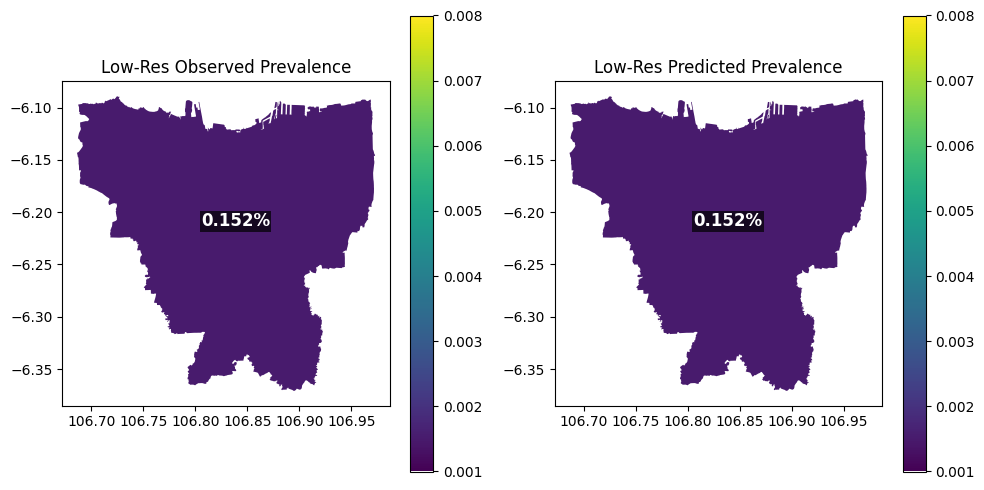

In [150]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

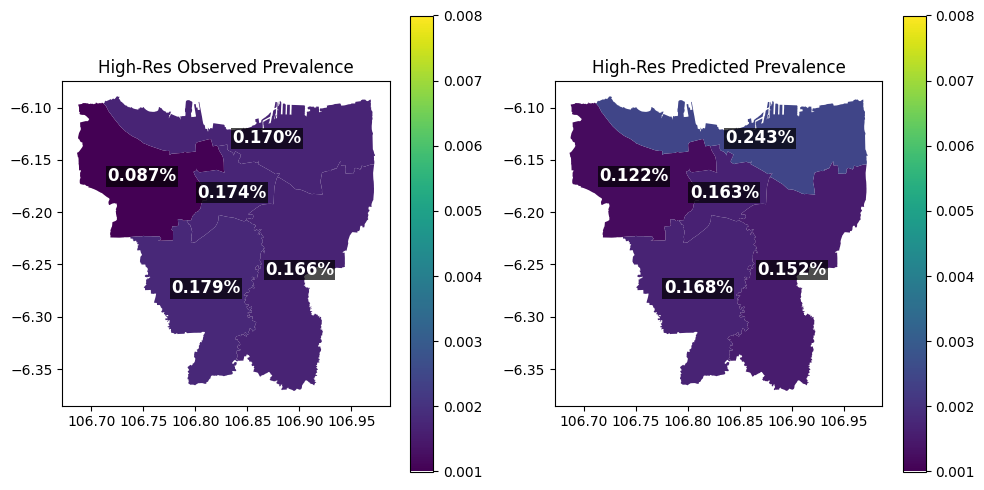

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [ ]:
#save the df predictions (change the year naming convention manually)
df_hi.to_csv("../data/df_hi_jkt_2020_aggVAE_preds.csv")

## MCMC Inference (see which one produces the best metric (change manually))

In [81]:
#load MCMC objects
with open("../model weights/aggVAEPrev/mcmc_jkt_2023_1min_z30_1000.pkl", "rb") as f_1:
    mcmc_1 = pickle.load(f_1)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_3min_z30_2000.pkl", "rb") as f_2:
    mcmc_2 = pickle.load(f_2)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_3min_z40_1000.pkl", "rb") as f_3:
    mcmc_3 = pickle.load(f_3)

with open("../model weights/aggVAEPrev/mcmc_jkt_2023_4min_z40_2000.pkl", "rb") as f_4:
    mcmc_4 = pickle.load(f_4)

### MCMC 1 (z = 30, n = 1000 Inference)

In [ ]:
args["z_dim"] = 30
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e50_h50_z30.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [ ]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [66]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_1.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_1,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_1.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0    100.24      9.90    100.09     83.21    115.97    750.00      1.00
             b_hdi      0.12      1.00      0.14     -1.66      1.63    286.63      1.01
     b_pop_density      0.07      1.01      0.07     -1.53      1.71    390.24      1.00
           b_urban      0.11      1.02      0.14     -1.59      1.72    261.76      1.01
full_pred_cases[0]   1561.61      8.55   1562.05   1548.64   1575.12    528.91      1.01
full_pred_cases[1]    401.71    111.46    401.85    221.37    586.26    153.74      1.01
full_pred_cases[2]    281.03    121.40    281.80     94.96    492.20    158.71      1.01
full_pred_cases[3]    452.69    111.12    453.59    274.88    638.40    152.26      1.01
full_pred_cases[4]    559.50    101.98    560.76    400.04    737.20    151.75      1.01
full_pred_cases[5]    522.66    101.76    522.32    360.77    696.49    157.25      1.01
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1561.608,8.548,1544.568,1577.866,0.370,0.374,598.0,575.0,1.01
pred_cases_out[1],401.708,111.463,192.986,604.072,8.790,4.509,162.0,287.0,1.01
pred_cases_out[2],281.028,121.398,57.448,507.012,9.375,4.537,167.0,297.0,1.01
pred_cases_out[3],452.687,111.125,258.690,666.797,8.801,4.500,160.0,260.0,1.01
pred_cases_out[4],559.500,101.984,371.597,747.594,8.109,4.072,160.0,271.0,1.01
pred_cases_out[5],522.660,101.760,338.918,715.924,7.952,4.137,164.0,276.0,1.01
lp[0],1561.816,6.121,1550.059,1573.676,0.190,0.198,1136.0,1144.0,1.01
lp[1],401.773,111.323,192.326,601.550,8.783,4.514,162.0,278.0,1.01
lp[2],280.964,121.179,58.716,508.813,9.366,4.536,168.0,304.0,1.01
lp[3],452.630,110.831,256.236,663.117,8.780,4.476,161.0,268.0,1.01


In [67]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [68]:
#calculate RMSE, MAE, MAPE / MAE as percentage of average no. of districts
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract the predicted and observed values
y_pred = df_hi["pred_cases"].values
y_true = df_hi["incidence"].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAE as percentage of average observed prevalence
mae_pct_avg_obs = (mae / np.mean(y_true)) * 100

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE as % of average observed prevalence: {mae_pct_avg_obs:.2f}%")

RMSE: 0.0012
MAE: 0.0010
MAPE: 51.72%
MAE as % of average observed prevalence: 51.22%


In [69]:
from scipy.stats import spearmanr

# Get predicted and observed values
y_pred = df_hi["pred_cases"]
y_true = df_hi["incidence"]

# Compute Spearman rank correlation
spearman_corr, spearman_p = spearmanr(y_true, y_pred)

print(f"Spearman correlation: {spearman_corr:.4f}")
print(f"p-value: {spearman_p:.4e}")

Spearman correlation: -0.2000
p-value: 7.4706e-01


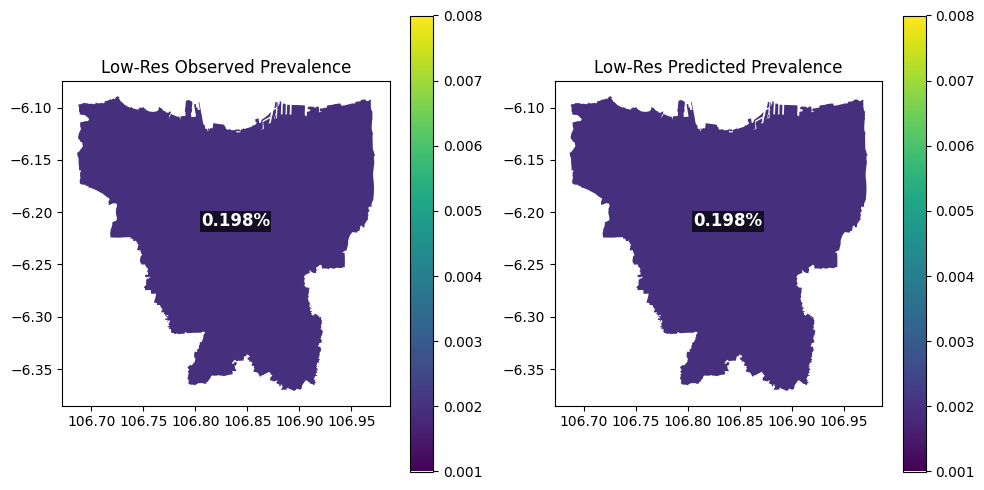

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

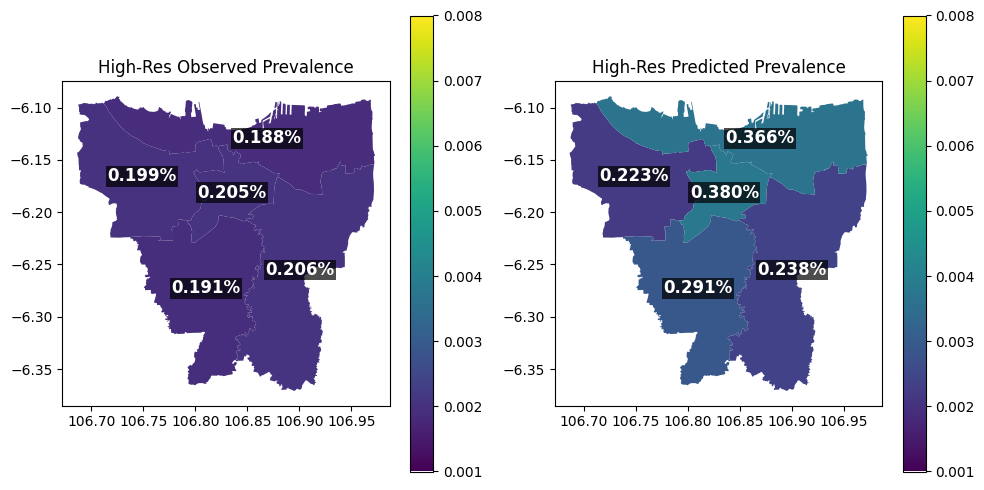

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [72]:
#save the df predictions (change the year naming convention manually)
#df_hi.to_csv("df_hi_jkt_2023_aggVAE_preds.csv")

### MCMC 2 (z = 30, n = 2000 Inference)

In [73]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_2,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_2.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.97     10.01     99.90     83.12    116.19   1500.61      1.00
             b_hdi      0.08      1.01      0.08     -1.63      1.69    560.03      1.00
     b_pop_density      0.10      0.99      0.10     -1.49      1.72    928.29      1.00
           b_urban      0.06      1.01      0.03     -1.60      1.67    451.30      1.01
full_pred_cases[0]   1561.69      8.90   1561.91   1547.41   1575.36   1380.95      1.00
full_pred_cases[1]    392.50    112.93    387.68    214.26    582.30    271.20      1.01
full_pred_cases[2]    271.93    123.63    267.84     85.87    492.20    272.88      1.01
full_pred_cases[3]    443.47    112.44    439.42    267.10    631.58    271.10      1.01
full_pred_cases[4]    550.78    102.95    548.13    379.87    716.76    271.83      1.01
full_pred_cases[5]    515.07    102.49    512.10    349.47    684.16    283.96      1.01
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1561.694,8.899,1543.698,1578.416,0.238,0.310,1502.0,1366.0,1.01
pred_cases_out[1],392.499,112.926,186.857,604.506,6.833,3.191,275.0,630.0,1.01
pred_cases_out[2],271.933,123.634,41.309,502.199,7.456,3.507,277.0,624.0,1.01
pred_cases_out[3],443.471,112.435,243.029,658.262,6.806,3.178,274.0,633.0,1.01
pred_cases_out[4],550.777,102.952,368.878,746.832,6.225,2.855,275.0,602.0,1.01
pred_cases_out[5],515.073,102.487,323.341,702.708,6.060,2.868,288.0,645.0,1.01
lp[0],1561.807,6.161,1550.022,1573.618,0.130,0.159,2407.0,2401.0,1.01
lp[1],392.564,112.705,181.980,598.917,6.819,3.192,275.0,640.0,1.01
lp[2],271.880,123.395,43.746,502.872,7.443,3.506,277.0,613.0,1.01
lp[3],443.356,112.264,241.761,655.217,6.798,3.167,274.0,615.0,1.01


In [74]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [75]:
#calculate RMSE, MAE, MAPE / MAE as percentage of average no. of districts
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract the predicted and observed values
y_pred = df_hi["pred_cases"].values
y_true = df_hi["incidence"].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAE as percentage of average observed prevalence
mae_pct_avg_obs = (mae / np.mean(y_true)) * 100

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE as % of average observed prevalence: {mae_pct_avg_obs:.2f}%")

RMSE: 0.0011
MAE: 0.0009
MAPE: 48.46%
MAE as % of average observed prevalence: 47.95%


In [76]:
from scipy.stats import spearmanr

# Get predicted and observed values
y_pred = df_hi["pred_cases"]
y_true = df_hi["incidence"]

# Compute Spearman rank correlation
spearman_corr, spearman_p = spearmanr(y_true, y_pred)

print(f"Spearman correlation: {spearman_corr:.4f}")
print(f"p-value: {spearman_p:.4e}")

Spearman correlation: -0.2000
p-value: 7.4706e-01


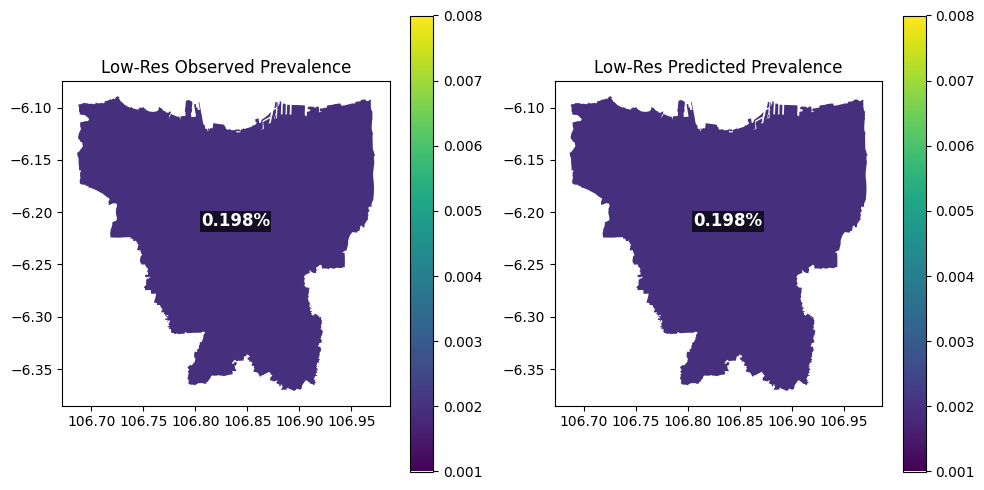

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

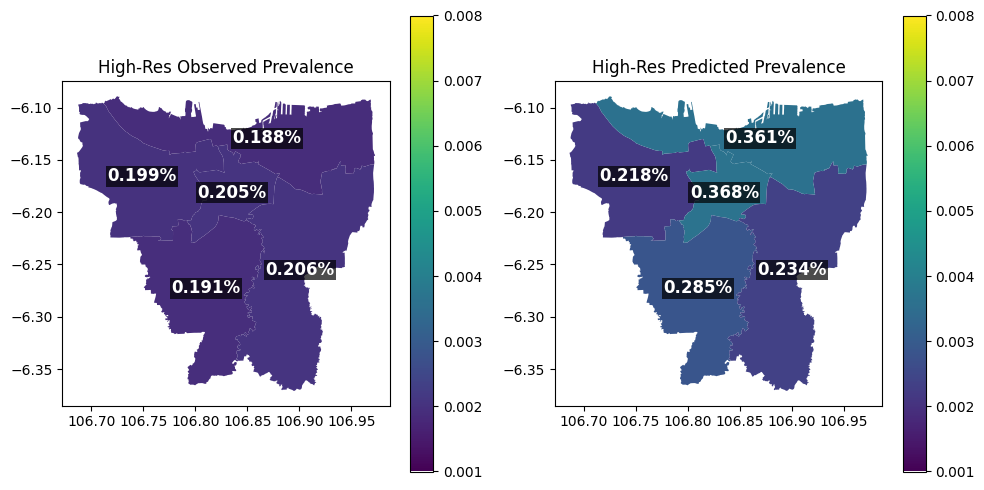

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [79]:
#save the df predictions (change the year naming convention manually)
#df_hi.to_csv("df_hi_jkt_2023_aggVAE_preds.csv")

### MCMC 3 (z = 40, n = 1000)

In [103]:
args["z_dim"] = 40
#open saved encoder
with open("../model weights/aggVAE/aggVAE_e29_h50_z40.pkl", "rb") as file:
    vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]

# save decoder params inside args
args["decoder_params"] = decoder_params

In [104]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi]
}

In [105]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_3.get_samples()

posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_3,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_3.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.26      9.83     99.68     83.72    114.89     61.90      1.05
             b_hdi     -0.37      1.10     -0.33     -2.23      1.46      8.57      1.27
     b_pop_density      0.33      0.97      0.32     -1.21      1.91     35.71      1.10
           b_urban     -0.31      1.39     -0.11     -2.67      1.56      3.49      1.64
full_pred_cases[0]   1557.16     13.36   1560.03   1539.70   1576.54     11.21      1.40
full_pred_cases[1]    214.16    183.06    176.60    -11.40    429.02      2.31      2.86
full_pred_cases[2]    126.64    146.01      8.37    -13.09    326.79      2.54      2.22
full_pred_cases[3]    257.65    203.07    212.67    -11.23    490.37      2.24      3.12
full_pred_cases[4]    339.13    237.29    334.41    -13.65    586.18      2.16      3.75
full_pred_cases[5]    332.03    211.15    393.10     -9.20    543.93      2.27      3.02
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1557.161,13.365,1524.115,1576.543,4.291,4.554,18.0,17.0,1.19
pred_cases_out[1],214.156,183.055,-13.123,466.704,84.566,15.922,5.0,28.0,2.04
pred_cases_out[2],126.636,146.013,-18.084,353.392,63.819,8.875,7.0,36.0,1.61
pred_cases_out[3],257.647,203.067,-13.528,525.974,95.191,23.445,5.0,58.0,2.10
pred_cases_out[4],339.133,237.288,-15.512,635.931,113.318,40.538,5.0,27.0,2.10
pred_cases_out[5],332.030,211.151,-10.150,582.005,98.536,38.692,6.0,22.0,2.04
lp[0],1559.488,8.428,1543.307,1576.077,2.291,2.280,21.0,14.0,1.14
lp[1],214.571,182.556,0.000,465.974,84.342,15.970,5.0,4.0,2.23
lp[2],127.030,145.658,0.000,344.522,63.640,8.902,6.0,5.0,1.98
lp[3],257.442,203.123,0.000,525.424,95.288,23.453,5.0,4.0,2.24


In [106]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [107]:
#calculate RMSE, MAE, MAPE / MAE as percentage of average no. of districts
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract the predicted and observed values
y_pred = df_hi["pred_cases"].values
y_true = df_hi["incidence"].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAE as percentage of average observed prevalence
mae_pct_avg_obs = (mae / np.mean(y_true)) * 100

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE as % of average observed prevalence: {mae_pct_avg_obs:.2f}%")

RMSE: 0.0005
MAE: 0.0005
MAPE: 24.79%
MAE as % of average observed prevalence: 24.87%


In [108]:
from scipy.stats import spearmanr

# Get predicted and observed values
y_pred = df_hi["pred_cases"]
y_true = df_hi["incidence"]

# Compute Spearman rank correlation
spearman_corr, spearman_p = spearmanr(y_true, y_pred)

print(f"Spearman correlation: {spearman_corr:.4f}")
print(f"p-value: {spearman_p:.4e}")

Spearman correlation: -0.5000
p-value: 3.9100e-01


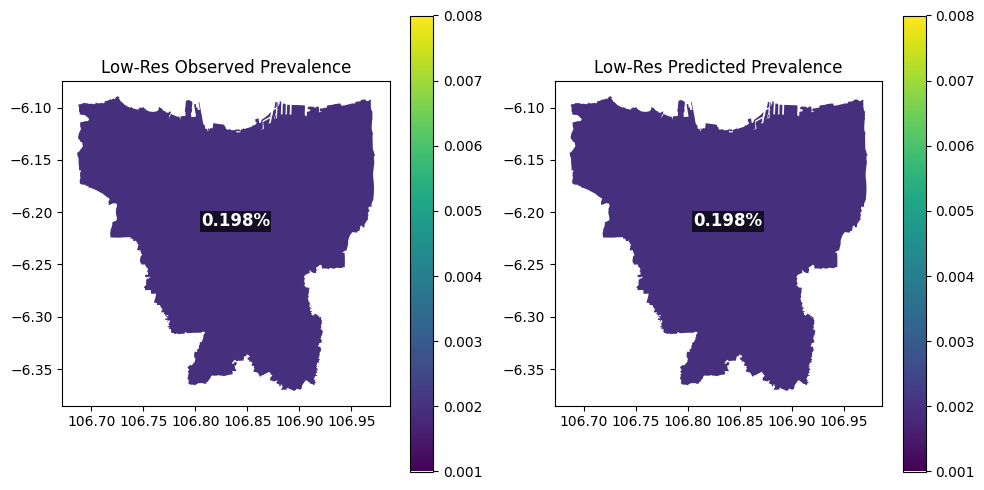

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

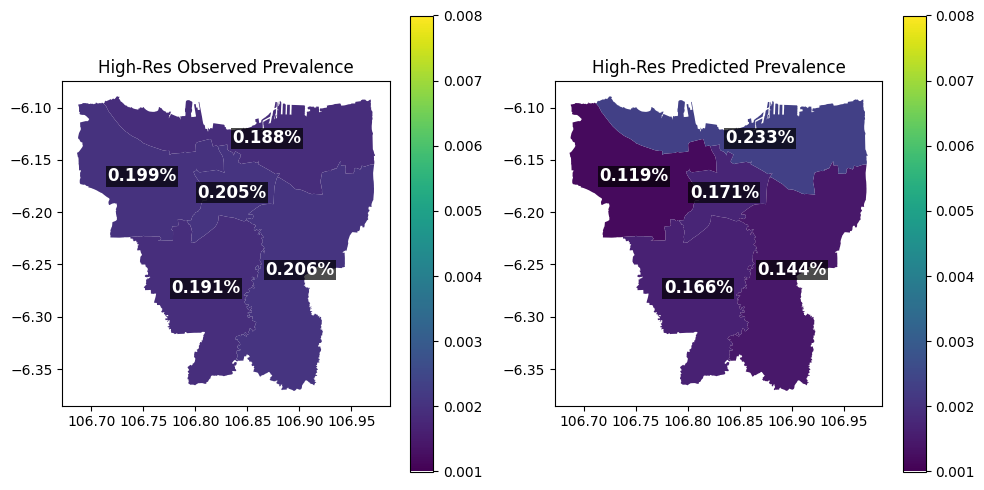

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [ ]:
#save the df predictions (change the year naming convention manually)
#df_hi.to_csv("df_hi_jkt_2023_aggVAE_preds.csv")

### MCMC 4 (z = 40, n = 2000)

In [97]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_4.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_4,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_4.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases_out", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                b0     99.02      9.73     98.96     82.69    113.73     90.83      1.07
             b_hdi     -0.30      1.02     -0.26     -2.05      1.34     14.29      1.14
     b_pop_density      0.23      0.94      0.21     -1.43      1.68     65.29      1.05
           b_urban     -0.20      1.29     -0.06     -2.40      1.80      5.33      1.33
full_pred_cases[0]   1559.32     10.90   1560.95   1546.46   1574.41     29.66      1.12
full_pred_cases[1]    212.02    167.80    201.64    -12.24    413.80      2.36      2.69
full_pred_cases[2]    107.13    133.52      7.79    -13.57    303.81      2.94      1.90
full_pred_cases[3]    250.62    189.06    240.69    -10.41    479.15      2.29      2.90
full_pred_cases[4]    338.52    228.36    366.19    -11.53    584.48      2.16      3.70
full_pred_cases[5]    362.98    191.93    420.40     -7.70    563.06      2.47      2.61
             sigma  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases_out[0],1559.320,10.898,1541.057,1577.083,2.122,3.531,72.0,21.0,1.06
pred_cases_out[1],212.016,167.805,-13.402,434.848,77.371,21.407,5.0,29.0,2.07
pred_cases_out[2],107.135,133.520,-17.426,328.144,56.048,15.190,7.0,32.0,1.62
pred_cases_out[3],250.618,189.056,-11.545,500.538,88.253,26.870,5.0,27.0,2.10
pred_cases_out[4],338.523,228.355,-13.961,600.567,109.466,43.109,5.0,28.0,2.13
pred_cases_out[5],362.980,191.935,-9.203,598.598,88.005,43.049,6.0,11.0,1.95
lp[0],1560.646,7.261,1547.113,1573.718,1.108,1.586,85.0,31.0,1.04
lp[1],212.483,167.138,0.000,430.864,77.052,21.267,5.0,4.0,2.24
lp[2],107.466,133.228,0.000,323.399,55.946,15.207,5.0,6.0,2.01
lp[3],250.477,189.121,0.000,497.830,88.342,26.927,5.0,4.0,2.24


In [98]:
mean_pred_cases = numpyro_data.posterior.pred_cases_out.values.mean(axis=(0, 1))
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [99]:
#calculate RMSE, MAE, MAPE / MAE as percentage of average no. of districts
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract the predicted and observed values
y_pred = df_hi["pred_cases"].values
y_true = df_hi["incidence"].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAE as percentage of average observed prevalence
mae_pct_avg_obs = (mae / np.mean(y_true)) * 100

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE as % of average observed prevalence: {mae_pct_avg_obs:.2f}%")

RMSE: 0.0006
MAE: 0.0006
MAPE: 30.27%
MAE as % of average observed prevalence: 30.33%


In [100]:
from scipy.stats import spearmanr

# Get predicted and observed values
y_pred = df_hi["pred_cases"]
y_true = df_hi["incidence"]

# Compute Spearman rank correlation
spearman_corr, spearman_p = spearmanr(y_true, y_pred)

print(f"Spearman correlation: {spearman_corr:.4f}")
print(f"p-value: {spearman_p:.4e}")

Spearman correlation: -0.7000
p-value: 1.8812e-01


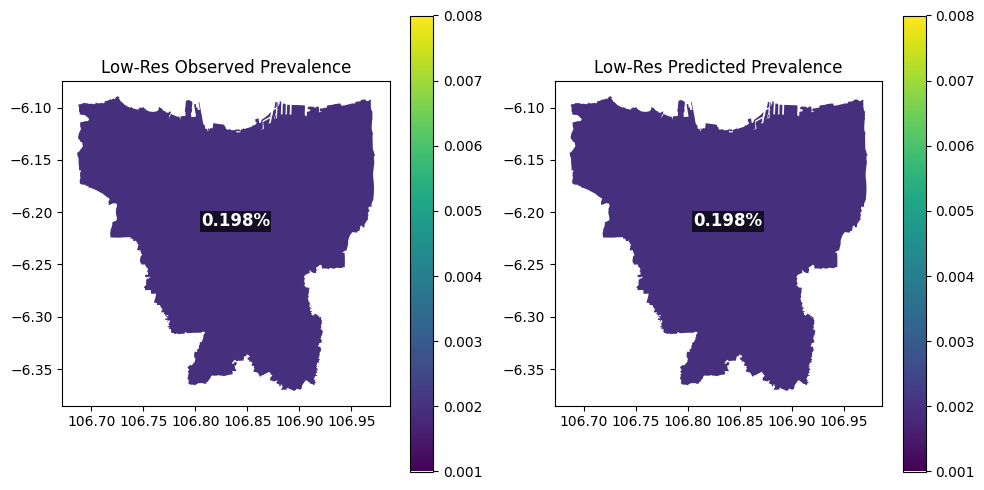

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

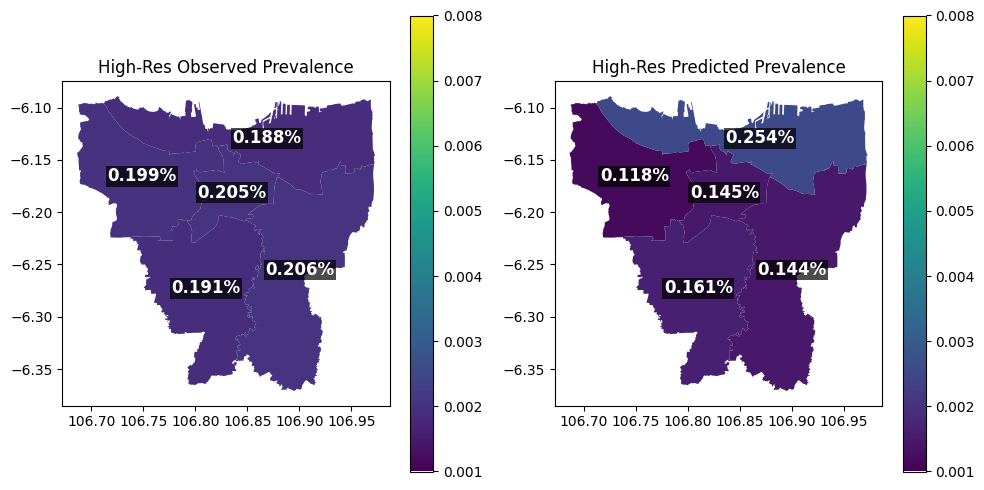

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [ ]:
#save the df predictions (change the year naming convention manually)
#df_hi.to_csv("df_hi_jkt_2023_aggVAE_preds.csv")

### MCMC 3 (z = 40, n = 1000 produces the best metric!)